In [86]:
import math
import pickle as pkl
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hypergeom_test import run_hypergeo_enrichr
from functools import partial

In [87]:
test_map = 1038963
ref_maps = [int(x.stem.split('_')[-1]) for x in Path.cwd().iterdir() if x.stem.startswith('sc_node_attributes')]

for ref_map in ref_maps:
    tsv_file = f"sc_node_attributes_{ref_map}.tsv"
    csv_file = f"sc_node_attributes_{ref_map}.csv"
    if Path(tsv_file).exists():
        df = pd.read_csv(Path.cwd() / tsv_file, sep='\t')
        df.to_csv(csv_file, index=False)
        Path(tsv_file).unlink()

assert test_map in ref_maps
ref_maps.remove(test_map)

def get_node_df(file_name, size_col='CD_MemberList_Size'):
    if Path(file_name).suffix == '.csv':
        df = pd.read_csv(Path.cwd() / file_name)
    df.sort_values(by=[size_col], ascending=False, inplace=True)
    df.index = np.arange(len(df))
    return df

test_file = f"sc_node_attributes_{test_map}.csv"
test_node_df = get_node_df(test_file)
ref_node_dfs = list(map(get_node_df, map(lambda x: f"sc_node_attributes_{x}.csv", ref_maps)))
# ref_node_df = get_node_df(f"u2os_node_table.csv", size_col='tsize')
ref_node_df = get_node_df(f"u2os_node_table.csv", size_col='CD_MemberList_Size')
print(ref_node_df.columns)
print(test_node_df.columns)
if 'Name' in test_node_df.columns:
    test_node_df.rename(columns={'Name': 'name'}, inplace=True)

Index(['__isKnown', 'Annotation', 'CD_MemberList', 'corum_adjPvalues',
       'corum_gene_overlaps', 'corum_jaccard_indexes', 'corum_terms',
       'estimated_size_nm', 'FINAL ANSWER ROUND 1', 'GO_cc_adjPvalues',
       'GO_cc_descriptions', 'GO_cc_gene_overlaps', 'GO_cc_jaccard_indexes',
       'GO_cc_terms', 'HCX::interactionNetworkUUID', 'HCX::memberName',
       'HiDeF_persistence', 'HPA_adjPvalues', 'HPA_gene_overlaps',
       'HPA_jaccard_indexes', 'HPA_terms', 'img_robustness', 'label',
       'max_jaccard_index', 'median_sim', 'MuSIC_robustness', 'name',
       'network_edges.MuSIC', 'network_edges.ppi_img',
       'network_edges.ppi_img.four_edges', 'ppi_robustness', 'selected',
       'shared name', 'CD_MemberList_Size', 'CCD_frac', 'member_ct'],
      dtype='object')
Index(['CD_AnnotatedMembers', 'CD_AnnotatedMembers_Overlap',
       'CD_AnnotatedMembers_Pvalue', 'CD_AnnotatedMembers_Size',
       'CD_CommunityName', 'CD_Labeled', 'CD_MemberList',
       'CD_MemberList_LogSi

In [88]:
print("Lengths of each node df:")
print(f"Test: {len(test_node_df)}")
print(f"Ref: {[len(x) for x in ref_node_dfs]}")
print(f"Ref Hash: {[h for h in ref_maps]}")
print("Number of genes in each df:")
print(f"Test: {test_node_df.iloc[0]['CD_MemberList_Size']}")
print(f"Ref: {[x.iloc[0]['CD_MemberList_Size'] for x in ref_node_dfs]}")

Lengths of each node df:
Test: 345
Ref: [334, 321, 329, 313, 318, 331, 319, 323, 334, 318, 320]
Ref Hash: [1586167, 1587907, 1586788, 1589197, 1586648, 1586466, 1588624, 1042864, 1038115, 1588145, 986625]
Number of genes in each df:
Test: 4971
Ref: [4971, 4971, 4971, 4971, 4971, 4971, 4971, 4971, 4971, 4971, 4971]


In [89]:
fdr_dfs = list(map(partial(run_hypergeo_enrichr, test_node_df), ref_node_dfs))

100%|██████████| 345/345 [00:07<00:00, 45.24it/s]


In [90]:
test_genes = set(test_node_df.iloc[0]['CD_MemberList'].split(' ')) & set(ref_node_df.iloc[0]['CD_MemberList'].split(' '))
filtered_ref_node_df = ref_node_df.copy()
filtered_ref_node_df['CD_MemberList'] = filtered_ref_node_df['CD_MemberList'].apply(lambda x: ' '.join([gene for gene in x.split(' ') if gene in test_genes]))
filtered_ref_node_df['CD_MemberList_Size'] = filtered_ref_node_df['CD_MemberList'].apply(lambda x: len(x.split(' ')))
filtered_test_node_df = test_node_df.copy()
filtered_test_node_df['CD_MemberList'] = filtered_test_node_df['CD_MemberList'].apply(lambda x: ' '.join([gene for gene in x.split(' ') if gene in test_genes]))
filtered_test_node_df['CD_MemberList_Size'] = filtered_test_node_df['CD_MemberList'].apply(lambda x: len(x.split(' ')))
fdr_df = run_hypergeo_enrichr(filtered_test_node_df, filtered_ref_node_df)

100%|██████████| 345/345 [00:06<00:00, 50.72it/s]


In [91]:
enriched_counts = [np.sum(np.sum(fdr_df.values < 1.0, axis=1) > 0) for fdr_df in fdr_dfs]
print(enriched_counts)
enriched = np.sum(np.stack([np.sum(fdr_df.values < 1.0, axis=1) > 0 for fdr_df in fdr_dfs]), axis=0)
threshold = 7
print(np.sum(enriched > threshold), f"enriched across at least {threshold} single-cell music maps")

test_node_df["enriched"] = enriched

test_node_df.to_csv(test_file, index=False)
print(test_node_df.columns)
columns = ["name", "CD_MemberList", "CD_MemberList_Size", "HiDeF_persistence",
           "CORUM_FDRs", "CORUM_terms", "CORUM_overlap_genes", "CORUM_jaccard_indexes",
           "GO_CC_descriptions", "GO_CC_FDRs", "GO_CC_overlap_genes", "GO_CC_jaccard_indexes", "GO_CC_terms",
           "HPA_FDRs", "HPA_overlap_genes", "HPA_jaccard_indexes", "HPA_terms"]
sc_enriched_clusters = test_node_df.iloc[enriched == len(fdr_dfs)][columns]
sc_enriched_clusters.to_csv(f"sc_enriched_clusters_{test_map}.csv", index=False)
sc_enriched_clusters.head()

[143, 145, 150, 139, 140, 142, 143, 145, 138, 131, 148]
108 enriched across at least 7 single-cell music maps
Index(['CD_AnnotatedMembers', 'CD_AnnotatedMembers_Overlap',
       'CD_AnnotatedMembers_Pvalue', 'CD_AnnotatedMembers_Size',
       'CD_CommunityName', 'CD_Labeled', 'CD_MemberList',
       'CD_MemberList_LogSize', 'CD_MemberList_Size', 'CORUM_FDRs',
       'CORUM_jaccard_indexes', 'CORUM_overlap_genes', 'CORUM_terms',
       'GO_CC_descriptions', 'GO_CC_FDRs', 'GO_CC_jaccard_indexes',
       'GO_CC_overlap_genes', 'GO_CC_terms', 'HiDeF_persistence', 'HPA_FDRs',
       'HPA_jaccard_indexes', 'HPA_overlap_genes', 'HPA_terms', 'name',
       'represents', 'selected', 'shared name', 'enriched'],
      dtype='object')


,name,CD_MemberList,CD_MemberList_Size,HiDeF_persistence,CORUM_FDRs,CORUM_terms,CORUM_overlap_genes,CORUM_jaccard_indexes,GO_CC_descriptions,GO_CC_FDRs,GO_CC_overlap_genes,GO_CC_jaccard_indexes,GO_CC_terms,HPA_FDRs,HPA_overlap_genes,HPA_jaccard_indexes,HPA_terms
0,C4971,LETMD1 UBE2M MAST1 RALGAPA1 MPO PCGF3 INTS6L A...,4971,96,NaN,NaN,NaN,NaN,cellular_component,1.0,"KDM1A,WDR7,NOC2L,HEATR5B,FKBP5,RCC1,GINS2,NMT1...",1.0,GO:0005575,NaN,NaN,NaN,NaN
1,C4972,B4GALT2 GPR180 SORT1 XRCC2 GOSR2 CAP1 LETMD1 I...,3289,19,NaN,NaN,NaN,NaN,cytoplasm|membrane|endomembrane system|cell pe...,2.567670394855298e-35|3.311871763274887e-82|2....,"NOC2L,HEATR5B,WDR7,SKA1,NMT1,RAF1,HLTF,CDK3,UB...",0.6214335421016005|0.5180495689655172|0.318997...,GO:0005737|GO:0016020|GO:0012505|GO:0071944|GO...,3.468810628999049e-08|3.531839399089142e-21|1....,"WDR7,HEATR5B,NMT1,RAF1,CDK3,UBXN6,GMNN,PXDNL,T...",0.364281956864808|0.17195375037059|0.171479080...,Cytosol|Plasma membrane|Vesicles|Mitochondria|...
2,C4973,DBF4B SNRPB2 DNTTIP2 ELL OSMR FOXRED1 RNF2 PCG...,1526,39,1.1793214934384825e-10,"Spliceosome, E complex","GEMIN8,RBM17,SF1,HNRNPA2B1,SFSWAP,GEMIN5,HNRNP...",0.10961214165261383,nuclear lumen|nucleoplasm|nucleus|intracellula...,2.960061024612006e-180|3.0364596152523386e-167...,"KDM1A,HEXIM1,FKBP5,RCC1,HNRNPA2B1,PIN1,ZNHIT1,...",0.4428629524196828|0.43186582809224316|0.42198...,GO:0031981|GO:0005654|GO:0005634|GO:0070013|GO...,5.966647850902522e-161|8.804591260566983e-33,"KDM1A,HEXIM1,FKBP5,GPX4,RCC1,HNRNPA2B1,PIN1,GF...",0.4280961182994455|0.14532459797498512,Nucleoplasm|Nucleoli
5,C4976,UBE2H CRYZ PAPSS1 OSBPL11 ECM1 RAB8A UBE2M HSD...,519,30,2.3345727745534833e-06|4.750989264259468e-05,"CCR4-NOT-TOB1 complex|CCR4-NOT complex, CNOT7-...","CNOT7,CNOT3,CNOT9,CNOT2,CNOT10,CNOT6L|CNOT7,CN...",0.12|0.11538461538461539,extracellular vesicle|extracellular membrane-b...,4.8982377025371486e-21|4.8982377025371486e-21|...,"CYB5R1,CRYZ,EEA1,SELENBP1,TPT1,HDHD2,BLMH,NARS...",0.14918190567853706|0.14918190567853706|0.1487...,GO:1903561|GO:0065010|GO:0070062|GO:0005615|GO...,4.1489437833043866e-08,"UBQLN2,EFL1,CYB5R1,CRYZ,SBDS,SH2D4A,TPT1,SH3GL...",0.12351326623970722,Cytosol
7,C4978,RSRC2 DNTTIP2 LYAR NOL8 MACROH2A2 FOXRED1 NOL6...,373,29,1.45371103965021e-10|1.1104803533898883e-09|2....,"Nop56p-associated pre-rRNA complex|Ribosome, c...","SRPK1,RBM28,RPL18A,RPS3A,RSL1D1,RPS7,RPL36,NPM...",0.18584070796460178|0.16346153846153846|0.1010...,nucleolus|ribonucleoprotein complex|nuclear lu...,1.5831313446479318e-65|3.9822943343400005e-25|...,"DNTTIP2,RBM15B,PAF1,PARP2,UTP3,RBM34,SPATS2L,G...",0.2257617728531856|0.14467408585055644|0.12331...,GO:0005730|GO:1990904|GO:0031981|GO:0030684|GO...,8.101210245612455e-55,"DNTTIP2,PURG,PARP2,PDGFRL,UTP3,RBM34,SPATS2L,G...",0.20833333333333334,Nucleoli


In [92]:
num_enriched = np.sum(fdr_df < 1.0, axis=1)
test_node_df["Annotation"] = ""
test_node_df['FINAL ANSWER ROUND 1'] = ""
test_node_df["enriched_music1.0"] = False
test_node_df['music1.0_enriched_names'] = [[] for _ in range(len(test_node_df))]
print(f"{np.sum(num_enriched)}\n")
for i in zip(test_node_df.index):
    enriched_indices = np.where(fdr_df.iloc[i] < 1.0)[0]
    members = set(test_node_df.iloc[i]["CD_MemberList"].split(" "))
    # def add_prop(prop_name, data):
    #     enriched_clusters.loc[enriched_clusters["name"] == test_node_df.iloc[i]["name"], prop_name] = data 
    # if len(enriched_indices) > 0 and test_node_df.iloc[i]["enriched"]:
    if len(enriched_indices) > 0 and test_node_df.iloc[i]["enriched"]:
        test_node_df["enriched_music1.0"].iloc[i] = True
        data = ref_node_df.iloc[enriched_indices]["Annotation"].values
        data = ["" if type(x) == float and math.isnan(x) else x for x in data]
        data = ",".join(data)
        test_node_df["Annotation"].iloc[i] = data
        test_node_df['FINAL ANSWER ROUND 1'].iloc[i] = ref_node_df.iloc[enriched_indices]["Annotation"].values[0]
        test_node_df['music1.0_enriched_names'].iloc[i] = ref_node_df.iloc[enriched_indices]["name"].values

        matched_members = []
        for match in ref_node_df.iloc[enriched_indices]["CD_MemberList"].values:
            matched_members.append(members & set(match.split(" ")))

        print(i, enriched_indices)
        print("Node Memberlist:", members)
        print("Ref Annotions:", ref_node_df.iloc[enriched_indices]["Annotation"].values)
        print("Ref Memberlist:", ref_node_df.iloc[enriched_indices]["CD_MemberList"].values)
        print("Memberlist Intersection:", matched_members)
        print("FDR:", fdr_df.iloc[i][enriched_indices].values)
        print()

new_columns = ["Annotation", "FINAL ANSWER ROUND 1", "enriched_music1.0", "music1.0_enriched_names"]
for column in new_columns:
    if column not in test_node_df.columns:
        columns.append(column)

enriched_clusters = test_node_df[test_node_df["enriched_music1.0"]][columns]
print(enriched_clusters["name"].unique())
print(len(enriched_indices))
enriched_clusters.to_csv(f"enriched_clusters_{test_map}.csv", index=False)
print(test_file)
print(test_node_df.columns)
test_node_df.to_csv(test_file, index=False)
# test_node_df.head()
print(len(enriched_clusters["name"].unique()))
enriched_clusters.head()

/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_node_df["enriched_music1.0"].iloc[i] = True
/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_node_df["Annotation"].iloc[i] = data
/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

87

(0,) [0]
Node Memberlist: {'FTSJ1', 'ETV3', 'IRS1', 'GXYLT2', 'NUDCD3', 'NHS', 'BRICD5', 'MYO6', 'CLTCL1', 'DHRS7B', 'MED27', 'CORO2B', 'CTDSPL2', 'INSR', 'SAP130', 'CCND1', 'ZNF281', 'MED1', 'NEFL', 'DDX46', 'CDH8', 'GRB2', 'RABGGTA', 'MRPL39', 'ABCA12', 'KCTD13', 'RAB5A', 'ERCC6L', 'SUZ12', 'GLIPR1L2', 'TRAT1', 'WAPL', 'DNAJB4', 'CAMK2N2', 'LTA4H', 'SRGAP2', 'POLE', 'VIRMA', 'S100P', 'ATL2', 'ANTXR1', 'DSTYK', 'CCDC93', 'SMCR8', 'CD63', 'NDUFB1', 'PIH1D1', 'ZNF609', 'SLC38A2', 'RAB11FIP3', 'NTNG1', 'GTF3C4', 'AZGP1', 'PRELID1', 'CENPP', 'PHF12', 'RNF111', 'RABGAP1', 'PMPCA', 'ARID4B', 'ACTR2', 'DHX36', 'PDCD5', 'TONSL', 'MRPL57', 'ZDHHC9', 'TPBG', 'GTF2H4', 'RPL10A', 'RNF34', 'ANAPC2', 'EHD1', 'OPTN', 'PSMD10', 'NECTIN3', 'PLEKHG2', 'SH3BP5', 'SUFU', 'RBM8A', 'NANS', 'SHTN1', 'ZBTB9', 'RELT', 'HBQ1', 'SUN2', 'POLR3C', 'RASSF8', 'NUP153', 'RAP1GDS1', 'KANSL2', 'TCEAL8', 'SF3B2', 'SUPT16H', 'TM7SF3', 'AAK1', 'ZBTB20', 'CAMK4', 'MUL1', 'KMT2A', 'DNAJC13', 'PSME1', 'AFDN', 'PEF1', 'M

/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_node_df["Annotation"].iloc[i] = data
/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_node_df['FINAL ANSWER ROUND 1'].iloc[i] = ref_node_df.iloc[enriched_indices]["Annotation"].values[0]
/var/folders/bq/fzr5srps2j1clknlxgts60300000gq/T/ipykernel_45436/877308267.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

70


,name,CD_MemberList,CD_MemberList_Size,HiDeF_persistence,CORUM_FDRs,CORUM_terms,CORUM_overlap_genes,CORUM_jaccard_indexes,GO_CC_descriptions,GO_CC_FDRs,GO_CC_overlap_genes,GO_CC_jaccard_indexes,GO_CC_terms,HPA_FDRs,HPA_overlap_genes,HPA_jaccard_indexes,HPA_terms
0,C4971,LETMD1 UBE2M MAST1 RALGAPA1 MPO PCGF3 INTS6L A...,4971,96,NaN,NaN,NaN,NaN,cellular_component,1.0,"KDM1A,WDR7,NOC2L,HEATR5B,FKBP5,RCC1,GINS2,NMT1...",1.0,GO:0005575,NaN,NaN,NaN,NaN
1,C4972,B4GALT2 GPR180 SORT1 XRCC2 GOSR2 CAP1 LETMD1 I...,3289,19,NaN,NaN,NaN,NaN,cytoplasm|membrane|endomembrane system|cell pe...,2.567670394855298e-35|3.311871763274887e-82|2....,"NOC2L,HEATR5B,WDR7,SKA1,NMT1,RAF1,HLTF,CDK3,UB...",0.6214335421016005|0.5180495689655172|0.318997...,GO:0005737|GO:0016020|GO:0012505|GO:0071944|GO...,3.468810628999049e-08|3.531839399089142e-21|1....,"WDR7,HEATR5B,NMT1,RAF1,CDK3,UBXN6,GMNN,PXDNL,T...",0.364281956864808|0.17195375037059|0.171479080...,Cytosol|Plasma membrane|Vesicles|Mitochondria|...
2,C4973,DBF4B SNRPB2 DNTTIP2 ELL OSMR FOXRED1 RNF2 PCG...,1526,39,1.1793214934384825e-10,"Spliceosome, E complex","GEMIN8,RBM17,SF1,HNRNPA2B1,SFSWAP,GEMIN5,HNRNP...",0.10961214165261383,nuclear lumen|nucleoplasm|nucleus|intracellula...,2.960061024612006e-180|3.0364596152523386e-167...,"KDM1A,HEXIM1,FKBP5,RCC1,HNRNPA2B1,PIN1,ZNHIT1,...",0.4428629524196828|0.43186582809224316|0.42198...,GO:0031981|GO:0005654|GO:0005634|GO:0070013|GO...,5.966647850902522e-161|8.804591260566983e-33,"KDM1A,HEXIM1,FKBP5,GPX4,RCC1,HNRNPA2B1,PIN1,GF...",0.4280961182994455|0.14532459797498512,Nucleoplasm|Nucleoli
4,C4975,RAD52 BCL7B DBF4B MAPK3 TOPORS SNRPB2 TLK1 PHF...,804,17,2.687172893088798e-09|1.8971582736952367e-09|8...,"Spliceosome, E complex|Spliceosome, A complex|...","GEMIN8,RBM17,SFSWAP,HNRNPA2B1,HNRNPR,RUVBL1,SN...",0.12944162436548223|0.11139896373056994|0.1026...,nucleoplasm|nuclear lumen|nuclear protein-cont...,1.6708669072990073e-113|2.6828286921504753e-10...,"KDM1A,FKBP5,RCC1,HNRNPA2B1,PIN1,ZNHIT1,GMEB1,N...",0.28612032212221694|0.2725647899910634|0.27067...,GO:0005654|GO:0031981|GO:0140513|GO:0005634|GO...,4.3858293442190666e-129|1.9324107127847093e-27,"KDM1A,FKBP5,GPX4,RCC1,HNRNPA2B1,PIN1,GFOD2,ZNH...",0.2784090909090909|0.10998877665544332,Nucleoplasm|Nuclear speckles
5,C4976,UBE2H CRYZ PAPSS1 OSBPL11 ECM1 RAB8A UBE2M HSD...,519,30,2.3345727745534833e-06|4.750989264259468e-05,"CCR4-NOT-TOB1 complex|CCR4-NOT complex, CNOT7-...","CNOT7,CNOT3,CNOT9,CNOT2,CNOT10,CNOT6L|CNOT7,CN...",0.12|0.11538461538461539,extracellular vesicle|extracellular membrane-b...,4.8982377025371486e-21|4.8982377025371486e-21|...,"CYB5R1,CRYZ,EEA1,SELENBP1,TPT1,HDHD2,BLMH,NARS...",0.14918190567853706|0.14918190567853706|0.1487...,GO:1903561|GO:0065010|GO:0070062|GO:0005615|GO...,4.1489437833043866e-08,"UBQLN2,EFL1,CYB5R1,CRYZ,SBDS,SH2D4A,TPT1,SH3GL...",0.12351326623970722,Cytosol


In [93]:
len(set(sc_enriched_clusters["name"].values) & set(enriched_clusters["name"].values))

32

# Sanity Checks

In [94]:
import pandas as pd

df = pd.read_csv("sc_node_attributes_986625.csv")
print(df.columns)
df.head()

Index(['CD_AnnotatedMembers', 'CD_AnnotatedMembers_Overlap',
       'CD_AnnotatedMembers_Pvalue', 'CD_AnnotatedMembers_Size',
       'CD_CommunityName', 'CD_Labeled', 'CD_MemberList',
       'CD_MemberList_LogSize', 'CD_MemberList_Size', 'CORUM_FDRs',
       'CORUM_jaccard_indexes', 'CORUM_overlap_genes', 'CORUM_terms',
       'GO_CC_descriptions', 'GO_CC_FDRs', 'GO_CC_jaccard_indexes',
       'GO_CC_overlap_genes', 'GO_CC_terms', 'HiDeF_persistence', 'HPA_FDRs',
       'HPA_jaccard_indexes', 'HPA_overlap_genes', 'HPA_terms', 'name',
       'represents', 'selected', 'shared name', 'enriched', 'Annotation',
       'FINAL ANSWER ROUND 1', 'enriched_music1.0', 'music1.0_enriched_names',
       'CCD_frac', 'member_ct'],
      dtype='object')


,CD_AnnotatedMembers,CD_AnnotatedMembers_Overlap,CD_AnnotatedMembers_Pvalue,CD_AnnotatedMembers_Size,CD_CommunityName,CD_Labeled,CD_MemberList,CD_MemberList_LogSize,CD_MemberList_Size,CORUM_FDRs,...,represents,selected,shared name,enriched,Annotation,FINAL ANSWER ROUND 1,enriched_music1.0,music1.0_enriched_names,CCD_frac,member_ct
0,NaN,0.0,0.0,0,NaN,False,PDCD5 CSNK1D GPC4 WDR83 SMTN PYCARD IL27RA BOR...,12.279,4971,NaN,...,C4971,False,C4971,11,Cell,Cell,True,Cluster0-0,0.103802,4971
1,NaN,0.0,0.0,0,NaN,False,CHCHD2 CSGALNACT1 PDCD5 FAM114A2 NAP1L4 NLRP10...,11.777,3509,NaN,...,C4972,False,C4972,11,Cytoplasm and plasma membrane,Cytoplasm and plasma membrane,True,Cluster1-0,0.094329,3509
2,NaN,0.0,0.0,0,NaN,False,CSGALNACT1 FAM114A2 NAP1L4 PITPNM3 APBB1 TOR1A...,10.876,1879,NaN,...,C4973,False,C4973,11,Endomembrane,Endomembrane,True,Cluster2-0,0.091006,1879
3,NaN,0.0,0.0,0,NaN,False,H1-4 RHOBTB1 METTL18 KDM5A POGK SMARCC2 BTBD9 ...,10.674,1634,NaN,...,C4974,False,C4974,11,Nucleus,Nucleus,True,Cluster1-1,0.122399,1634
4,NaN,0.0,0.0,0,NaN,False,ZNF521 POLE H1-4 CWF19L2 CUL1 RPAP2 ZNF423 ARI...,10.006,1028,1.1533836580586058e-07,...,C4975,False,C4975,11,"Nucleus,Nucleoplasm",Nucleus,True,['Cluster1-1' 'Cluster2-2'],0.105058,1028


<Axes: xlabel='CD_MemberList_LogSize', ylabel='HiDeF_persistence'>

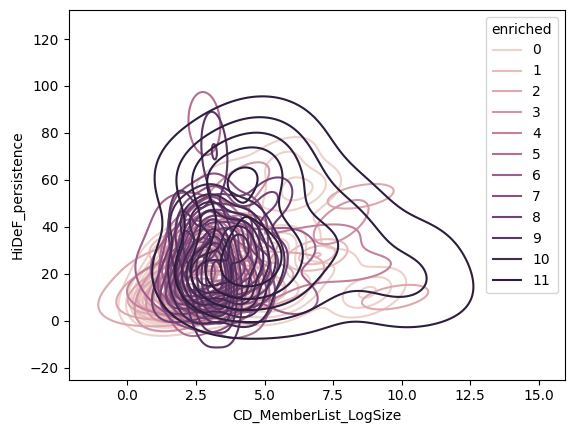

In [95]:
import seaborn as sns

sns.kdeplot(df, x="CD_MemberList_LogSize", y="HiDeF_persistence", hue="enriched")

<Axes: xlabel='HiDeF_persistence', ylabel='Density'>

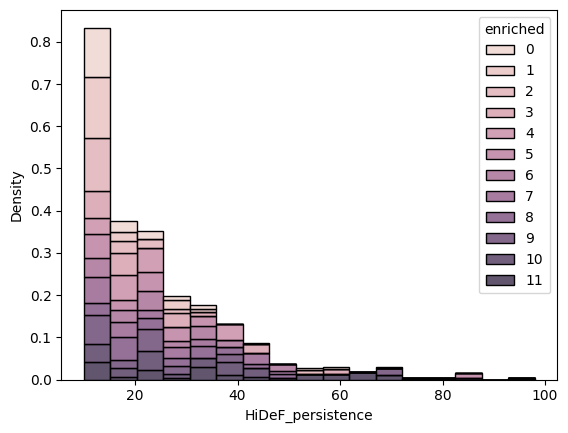

In [96]:
sns.histplot(df, x="HiDeF_persistence", hue="enriched", common_norm=False, stat="density", multiple="stack")


In [97]:
df_og = pd.read_csv("u2os_node_table.csv")
print(df_og.columns)
df_og.head()

Index(['__isKnown', 'Annotation', 'CD_MemberList', 'corum_adjPvalues',
       'corum_gene_overlaps', 'corum_jaccard_indexes', 'corum_terms',
       'estimated_size_nm', 'FINAL ANSWER ROUND 1', 'GO_cc_adjPvalues',
       'GO_cc_descriptions', 'GO_cc_gene_overlaps', 'GO_cc_jaccard_indexes',
       'GO_cc_terms', 'HCX::interactionNetworkUUID', 'HCX::memberName',
       'HiDeF_persistence', 'HPA_adjPvalues', 'HPA_gene_overlaps',
       'HPA_jaccard_indexes', 'HPA_terms', 'img_robustness', 'label',
       'max_jaccard_index', 'median_sim', 'MuSIC_robustness', 'name',
       'network_edges.MuSIC', 'network_edges.ppi_img',
       'network_edges.ppi_img.four_edges', 'ppi_robustness', 'selected',
       'shared name', 'CD_MemberList_Size', 'CCD_frac', 'member_ct'],
      dtype='object')


,__isKnown,Annotation,CD_MemberList,corum_adjPvalues,corum_gene_overlaps,corum_jaccard_indexes,corum_terms,estimated_size_nm,FINAL ANSWER ROUND 1,GO_cc_adjPvalues,...,name,network_edges.MuSIC,network_edges.ppi_img,network_edges.ppi_img.four_edges,ppi_robustness,selected,shared name,CD_MemberList_Size,CCD_frac,member_ct
0,0,NaN,ASPH ATP2A1 BCAP31 CALR CALU CHM CYFIP2 DNAJB1...,NaN,NaN,NaN,NaN,37.653560,NaN,NaN,...,Cluster5-1,https://www.ndexbio.org/viewer/networks/c646b9...,https://www.ndexbio.org/viewer/networks/a1ef3e...,https://test.ndexbio.org/viewer/networks/9132a...,0.000000,False,Cluster5-1,29,0.068966,29
1,0,NaN,SPAG1 HSPA2 HSPA8 DPH2 HSPA4 BAG1 BCL9L HSF1 H...,NaN,NaN,NaN,NaN,16.899976,NaN,NaN,...,Cluster2-33,https://www.ndexbio.org/viewer/networks/b5c283...,https://www.ndexbio.org/viewer/networks/675efc...,https://test.ndexbio.org/viewer/networks/228fd...,0.536667,False,Cluster2-33,15,0.200000,15
2,0,NaN,SHMT1 TRAPPC4 CKS2 CKS1B CIAO3 CCNB1 SKP1 EEF1...,NaN,NaN,NaN,NaN,98.530323,Cell cycle regulation systems,4.50e-14 | 8.25e-14 | 3.57e-09,...,Cluster1-4,https://www.ndexbio.org/viewer/networks/c6228f...,https://www.ndexbio.org/viewer/networks/9ea459...,https://test.ndexbio.org/viewer/networks/98314...,0.956667,False,Cluster1-4,64,0.187500,64
3,0,NaN,NACC1 TTC5 WDR81 ZNF281,NaN,NaN,NaN,NaN,3.390965,NaN,NaN,...,Cluster2-71,https://www.ndexbio.org/viewer/networks/b5a07c...,https://www.ndexbio.org/viewer/networks/641ec5...,https://test.ndexbio.org/viewer/networks/294c1...,0.000000,False,Cluster2-71,4,0.000000,4
4,0,NaN,CRELD1 GSTM3 TTK RPL35 RPL10L EIF4G1 NFU1 RPL1...,1.36e-14 | 2.07e-09 | 7.90e-11 | 4.19e-04 | 7....,RPS10 RPL35 RPL30 RPS11 RPL14 RPL13 RPL18 RPS8...,0.243 | 0.214 | 0.148 | 0.136 | 0.125,"Ribosome, cytoplasmic | 60S ribosomal subunit,...",16.899976,Ribosome associated proteins,1.38e-16 | 2.46e-11 | 6.44e-04 | 8.46e-09 | 5....,...,Cluster5-3,https://www.ndexbio.org/viewer/networks/c5fc90...,https://www.ndexbio.org/viewer/networks/9b4920...,https://test.ndexbio.org/viewer/networks/9f096...,0.000000,False,Cluster5-3,15,0.000000,15


<Axes: xlabel='HiDeF_persistence', ylabel='Density'>

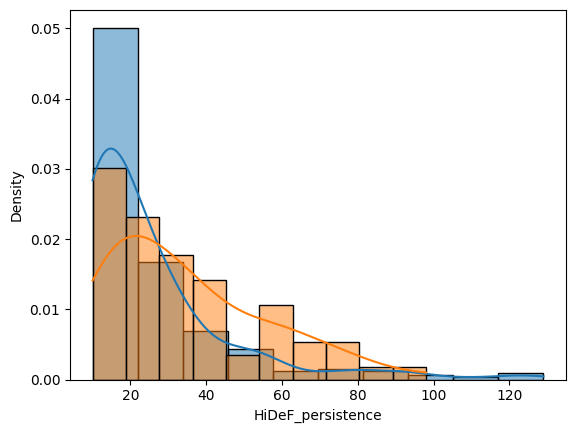

In [98]:
sns.histplot(df_og, x="HiDeF_persistence", common_norm=False, stat="density", bins=10, kde=True)
sns.histplot(df[df["enriched_music1.0"]], x="HiDeF_persistence", common_norm=False, stat="density", bins=10, kde=True)

KeyError: "None of [Index([11, 11, 11, 11, 11, 11,  2, 11,  0,  0,\n       ...\n        0,  6,  2,  1,  0,  0,  1,  1,  8,  5],\n      dtype='int64', length=320)] are in the [columns]"

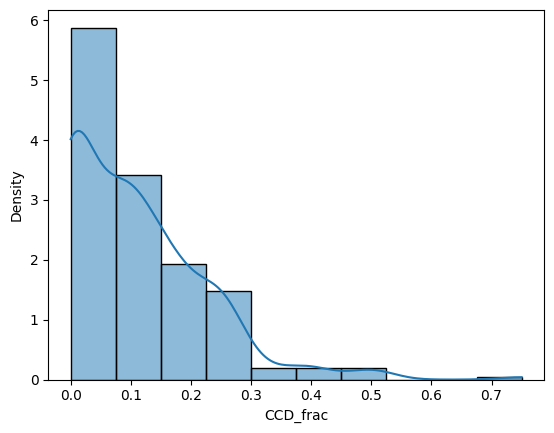

In [99]:
sns.histplot(df_og, x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True)
# sns.histplot(df, x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True, hue="enriched_music1.0")
# sns.histplot(df, x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True, hue="enriched")
sns.histplot(df[df["enriched"]], x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True)
sns.histplot(df[df["enriched_music1.0"]], x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True)
# sns.histplot(df[df["enriched"] != True], x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True)

NameError: name 'plt' is not defined

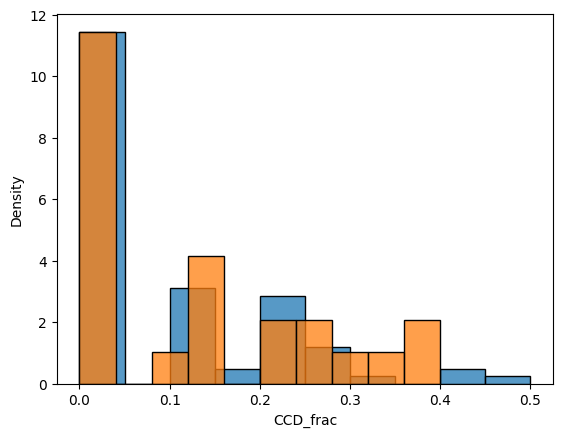

In [ ]:
size_thresh = 20
size_range = list(range(5, 10))
# not_enriched = df[(df["enriched"] != True) & (df["CD_MemberList_Size"] < size_thresh)]
# enriched = df[(df["enriched"] == True) & (df["CD_MemberList_Size"] < size_thresh)]
# enriched_music1 = df[(df["enriched_music1.0"] == True) & (df["CD_MemberList_Size"] < size_thresh)]
background = df[df["CD_MemberList_Size"].isin(size_range)]
not_enriched = df[(df["enriched"] != True) & (df["CD_MemberList_Size"].isin(size_range))]
enriched = df[(df["enriched"] == True) & (df["CD_MemberList_Size"].isin(size_range))]
enriched_music1 = df[(df["enriched_music1.0"] == True) & (df["CD_MemberList_Size"].isin(size_range))]
legend_labels = [f"Background (n={len(background)})", f"Not enriched (n={len(not_enriched)})", f"Enriched (n={len(enriched)})", f"Enriched MuSIC (n={len(enriched_music1)})"]
# sns.histplot(background, x="CCD_frac", stat="density", bins=10)
sns.histplot(not_enriched, x="CCD_frac", stat="density", bins=10)
sns.histplot(enriched, x="CCD_frac", stat="density", bins=10)
# sns.histplot(enriched_music1, x="CCD_frac", common_norm=False, stat="density", bins=10, kde=True)
plt.legend(legend_labels[1:3])

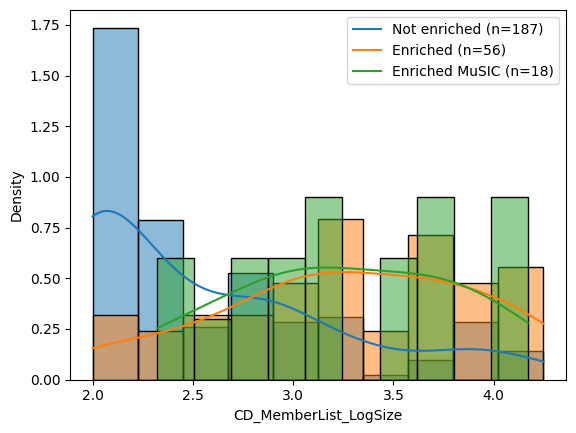

In [ ]:
size_thresh = 20
not_enriched = df[(df["enriched"] != True) & (df["CD_MemberList_Size"] < size_thresh)]
enriched = df[(df["enriched"] == True) & (df["CD_MemberList_Size"] < size_thresh)]
enriched_music1 = df[(df["enriched_music1.0"] == True) & (df["CD_MemberList_Size"] < size_thresh)]
sns.histplot(not_enriched, x="CD_MemberList_LogSize", stat="density", bins=10, kde=True)
sns.histplot(enriched, x="CD_MemberList_LogSize", stat="density", bins=10, kde=True)
sns.histplot(enriched_music1, x="CD_MemberList_LogSize", common_norm=False, stat="density", bins=10, kde=True)
plt.legend([f"Not enriched (n={len(not_enriched)})", f"Enriched (n={len(enriched)})", f"Enriched MuSIC (n={len(enriched_music1)})"])

<Axes: xlabel='CCD_frac', ylabel='CD_MemberList_LogSize'>

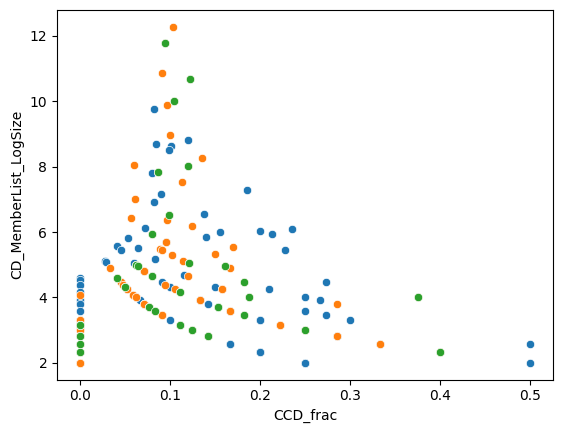

In [ ]:
not_enriched = df[(df["enriched"] != True)]
enriched = df[(df["enriched"] == True)]
enriched_music1 = df[(df["enriched_music1.0"] == True)]
sns.scatterplot(not_enriched, x="CCD_frac", y="CD_MemberList_LogSize")
sns.scatterplot(enriched, x="CCD_frac", y="CD_MemberList_LogSize")
sns.scatterplot(enriched_music1, x="CCD_frac", y="CD_MemberList_LogSize")

In [ ]:
print(df.columns)

Index(['CD_AnnotatedMembers', 'CD_AnnotatedMembers_Overlap',
       'CD_AnnotatedMembers_Pvalue', 'CD_AnnotatedMembers_Size',
       'CD_CommunityName', 'CD_Labeled', 'CD_MemberList',
       'CD_MemberList_LogSize', 'CD_MemberList_Size', 'CORUM_FDRs',
       'CORUM_jaccard_indexes', 'CORUM_overlap_genes', 'CORUM_terms',
       'GO_CC_descriptions', 'GO_CC_FDRs', 'GO_CC_jaccard_indexes',
       'GO_CC_overlap_genes', 'GO_CC_terms', 'HiDeF_persistence', 'HPA_FDRs',
       'HPA_jaccard_indexes', 'HPA_overlap_genes', 'HPA_terms', 'name',
       'represents', 'selected', 'shared name', 'enriched', 'Annotation',
       'FINAL ANSWER ROUND 1', 'enriched_music1.0', 'music1.0_enriched_names',
       'CCD_frac', 'member_ct'],
      dtype='object')


In [ ]:
import json
from pprint import pprint

test_map = json.load(open("sc_hierarchy_986625.cx"))
pprint(test_map)

[{'numberVerification': [{'longNumber': 281474976710655}]},
 {'metaData': [{'consistencyGroup': 1,
                'elementCount': 320,
                'idCounter': 320,
                'name': 'nodes',
                'properties': [],
                'version': '1.0'},
               {'consistencyGroup': 1,
                'elementCount': 364,
                'idCounter': 364,
                'name': 'edges',
                'properties': [],
                'version': '1.0'},
               {'consistencyGroup': 1,
                'elementCount': 5,
                'idCounter': 5,
                'name': 'networkAttributes',
                'properties': [],
                'version': '1.0'},
               {'consistencyGroup': 1,
                'elementCount': 7360,
                'idCounter': 7360,
                'name': 'nodeAttributes',
                'properties': [],
                'version': '1.0'},
               {'elementCount': 3,
                'idCounter': 4,
      

In [ ]:
# venn diagram of enriched clusters vs enriched clusters in music
print("not enriched", len(df[df["enriched"] != True]))
print("enriched", len(df[df["enriched"] == True]))
print("enriched_music1", len(df[df["enriched_music1.0"] == True]))
print("enriched & enriched_music1", len(df[(df["enriched"] == True) & (df["enriched_music1.0"] == True)]))

not enriched 224
enriched 96
enriched_music1 33
enriched & enriched_music1 33
